In [33]:
import pandas as pd
import numpy as np

import scipy.stats as stats


In [34]:
import sys
sys.path.append("..")  
import metaprivBIDS_stat as ST
from metapriv_stat import plot_calc
from metapriv_stat import rst_outlier_case2

In [3]:
STRESS = 'https://s3.amazonaws.com/openneuro.org/ds004228/phenotype/questionnaires.tsv?versionId=SdOOI_jJreOTd9M9UsxjhcUPtFoA4Zvy'
STRESS = pd.read_csv(STRESS, sep='\t')
STRESS['age_scan'] = STRESS['age_scan'].astype(int)
# Mapping dictionary
race_mapping = {
    'black': 'Black',
    'white': 'White',
    'asian': 'Asian',
    'multiracial': 'Multiracial',
    'other': 'Other'
}

# Initialize 'Race' column with 'Unknown'
STRESS['Race'] = 'Unknown'

# Update 'Race' column based on conditions
for column, race in race_mapping.items():
    STRESS.loc[STRESS[column] == 1, 'Race'] = race

# Drop the original binary columns if no longer needed
STRESS = STRESS.drop(columns=race_mapping.keys())
STRESS.drop(columns=['hispanic'], inplace=True)
STRESS.to_csv('data_ds004228/STRESS_dataset_ds004228.csv', sep=',', index=False)
# Mapping dictionary
na_percentage = STRESS.isna().mean() * 100
na_percentage = na_percentage[na_percentage >= 10].sort_values(ascending=False)
na_percentage

parent             57.142857
pos_content_avg    57.142857
pos_affect_avg     57.142857
neg_content_avg    57.142857
neg_affect_avg     57.142857
pos_parent         57.142857
neg_parent         57.142857
parent2_edu        14.285714
income_median      10.000000
dtype: float64

In [5]:
suda = pd.read_csv('data_ds004228/suda_ds004228.csv', sep=',')
pif = pd.read_csv('data_ds004228/pif_ds004228.csv', sep=',',index_col='Unnamed: 0').sort_index()
suda_field_score =  pd.read_csv('data_ds004228/att_suda.csv', sep=',').drop(columns=['Unnamed: 0'], errors='ignore')
k_combined_field =  pd.read_csv('data_ds004228/normalized_difference_stress.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})
k_combined_all = pd.read_csv('data_ds004228/k-combined-3-7.csv', sep=',')
k_combined_field_non_risk = pd.read_csv('data_ds004228/normalized_difference_results_non.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})


        ROW LEVEL CORRELATION      

Spearman Rank Correlation between suda & pif: 0.82, P-value: 0.0000
Kendall's Tau between suda & pif: 0.63, p-value: 0.0000


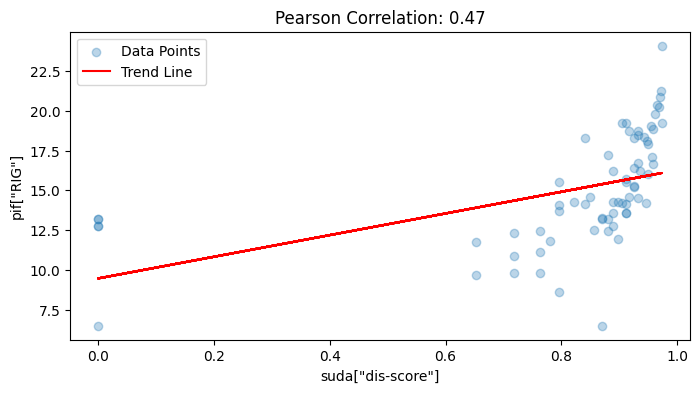

____________________________________________________________________________________

      FIELD LEVEL CORRELATIONS     

Pearson Correlation between SUDA & PIF field level: 0.63
Pearson Correlation between K-combined & PIF field level: 0.21
Pearson Correlation between SUDA & K-combined field level: 0.67


Spearman Rank Correlation between PIF & SUDA: 0.32, P-value: 0.4821
Spearman Rank Correlation between PIF & K: -0.02, P-value: 0.9666
Spearman Rank Correlation between SUDA & K: 0.39, P-value: 0.3817


In [6]:
ST.stats(suda, pif, suda_field_score, k_combined_field)

In [7]:
sum_score_df  = ST.calculate_summed_dis_scores(k_combined_all, STRESS, sample_fraction=0.3, missing_value= np.nan)

Spearman Correlation between Suda sum and K-combined: 0.19
Pearson correlation to Suda sum & K-combined 0.09607884994607975
________________________________________________________________________
Pearson Correlation: 0.09607884994607975


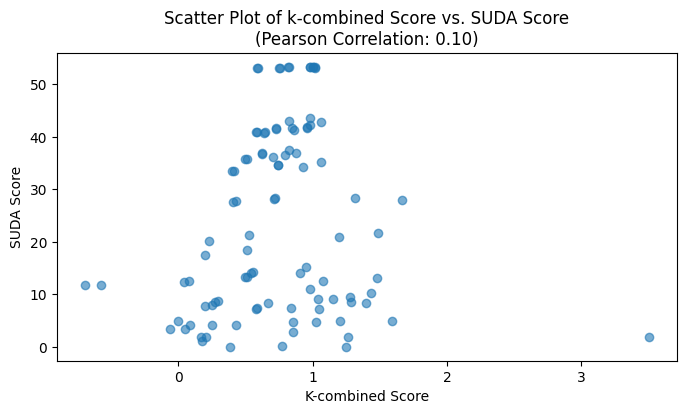

________________________________________________________________________


Spearman Correlation between PIF 95% and K-combined: 0.49
Pearson correlation to PIF 95% & K-combined 0.38393489893672644


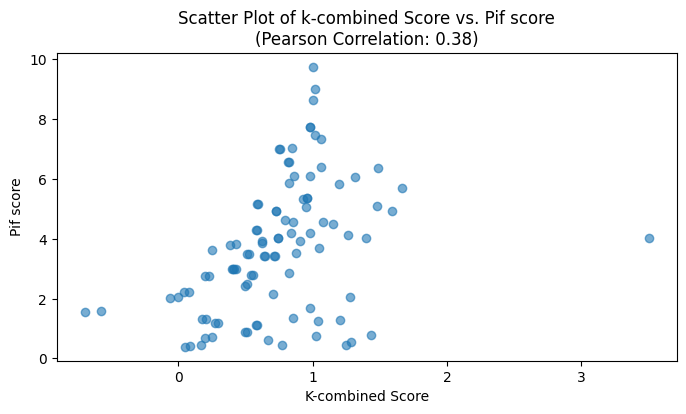

________________________________________________________________________


Spearman Correlation between PIF 95% and SUDA: 0.71
Pearson correlation to PIF 95% & SUDA 0.7376789741959202


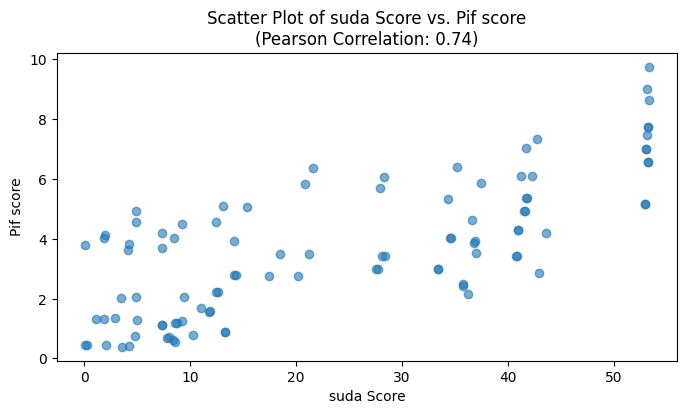

In [8]:
plot_calc(sum_score_df)

# T-test between risky and non-risky k-global values for variables. 


### Non risk variables

In [11]:
k_combined_field_non_risk

,variable,Normalized Difference
0,piper_motion,0.0
1,pos_affect_HO_amyg,0.0
2,neg_affect_HO_amyg,0.0
3,parent_child_HO_amyg,0.0
4,parent_child_ses_zstat1,0.0
5,pos_affect_neg_parent_zstat2_1,0.0
6,pos_affect_neg_parent_zstat2_2,0.0
7,pos_parent,0.0
8,pos_content_avg,0.0
9,pos_affect_avg,0.0


### Risk Variables 

In [13]:
k_combined_field

,variable,Normalized Difference
0,age_scan,1.8
1,parent1_edu,1.0
2,Race,0.4
3,income_median,0.0
4,parent2_edu,0.0
5,male,0.0
6,income_rank,0.0


In [18]:
mean_risk_values = (k_combined_field['Normalized Difference']).mean()
print('Mean, risk identifiers:',mean_risk_values)

mean_risk_values = (k_combined_field_non_risk['Normalized Difference']).mean()
print('Mean, non-risk identifiers:',mean_risk_values)

t, p = stats.ttest_ind(k_combined_field['Normalized Difference'], k_combined_field_non_risk['Normalized Difference'])
print('t:',t,'p-value:', p)

Mean, risk identifiers: 0.45714285714285713
Mean, non-risk identifiers: 0.0
t: 2.785919757914012 p-value: 0.010774332265923062


### PIF & SUDA Outliers 

In [27]:
class_outliers, madn, mad, outlier_indices, above_outlier_indices = ST.rst_outlier_case2(suda, 'dis-score')
print(len(above_outlier_indices))
class_outliers, madn, mad, outlier_indices, above_outlier_indices = rst_outlier_case2(pif, 'RIG')
print(len(above_outlier_indices))
print(above_outlier_indices)
STRESS.loc[7]

0
2
[7, 8]


participant_id                      sub-08
dataset                                  1
age_scan                                 9
male                                     0
parent1_edu                           16.0
parent2_edu                           10.0
income_rank                            1.0
income_median                       8500.0
les_1y_sum                            15.0
parent                                 mom
pos_content_avg                       5.25
pos_affect_avg                    3.583333
neg_content_avg                   2.666667
neg_affect_avg                    2.333333
pos_parent                        4.416667
neg_parent                             2.5
piper_motion                      0.104387
piper_outliers                           4
pos_affect_HO_amyg               -1.131494
neg_affect_HO_amyg               -0.797679
parent_child_HO_amyg              1.040862
parent_child_ses_zstat1           0.320595
pos_affect_neg_parent_zstat2_1   -1.846616
pos_affect_

In [24]:
pif.sort_values('RIG', ascending=True)

,male,Race,parent2_edu,parent1_edu,age_scan,income_median,income_rank,RIG
34,0.544321,0.807355,0.000000,2.014874,3.129283,0.000000,0.000000,6.495832
44,0.544321,0.807355,0.000000,2.014874,3.129283,0.000000,0.000000,6.495832
46,0.544321,0.807355,1.807355,3.129283,2.321928,0.000000,0.000000,8.610241
22,0.544321,0.738603,1.807355,1.485427,1.518715,1.807355,1.807355,9.709131
37,0.544321,0.807355,1.807355,1.485427,1.518715,1.807355,1.807355,9.777882
...,...,...,...,...,...,...,...,...
13,0.544321,2.321928,2.129283,2.544321,2.428843,5.129283,5.129283,20.227261
49,1.669851,4.129283,2.129283,3.129283,2.222392,3.544321,3.544321,20.368734
28,1.669851,2.669851,2.959358,2.321928,4.129283,3.544321,3.544321,20.838913
8,1.669851,2.669851,3.544321,3.129283,3.129283,3.544321,3.544321,21.231230


In [31]:
STRESS['Race'].value_counts()

White          40
Black          14
Multiracial    11
Asian           4
Other           1
Name: Race, dtype: int64